In [1]:
import sys
assert sys.version_info >= (3, 5)    #assert(가정 설정문)으로 값 보증. 맞지 않을 시 에러 띄움.
import sklearn
assert sklearn.__version__ >= "0.20"
import numpy as np
import os
%matplotlib inline    #브라우저에서 바로 그림을 볼 수 있도록 함.
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#파일 저장 경로 설정(그림)
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 데이터 다운받기

In [2]:
import tarfile
import urllib.request

#housing 데이터셋 다운로드

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

In [3]:
import pandas as pd  #pandas로 데이터를 읽어 data mining을 할 수 있도록 함.
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path,'housing.csv')
    return pd.read_csv(csv_path)

1. total_rooms: 전체 방의 개수
2. total_bedrooms : 전체 침실 개수
3. population : 인구 수
4. households : 세대 수
5. median_income : 중간 소득
6. median_house_value : 중간 주택 가격
7. ocean_proximity : 바다 근접도
8. longitude : 경도
9. latitude : 위도
10. housing_median_age : 주택 지어진 기간(중앙값)

## housing을 자기 학번으로 변경하기

In [4]:
sid181061 = load_housing_data()  
sid181061.head() #데이터 처음 다섯 항 보기

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## 데이터 분포 출력해보기

그림 저장: attribute_histogram_plots


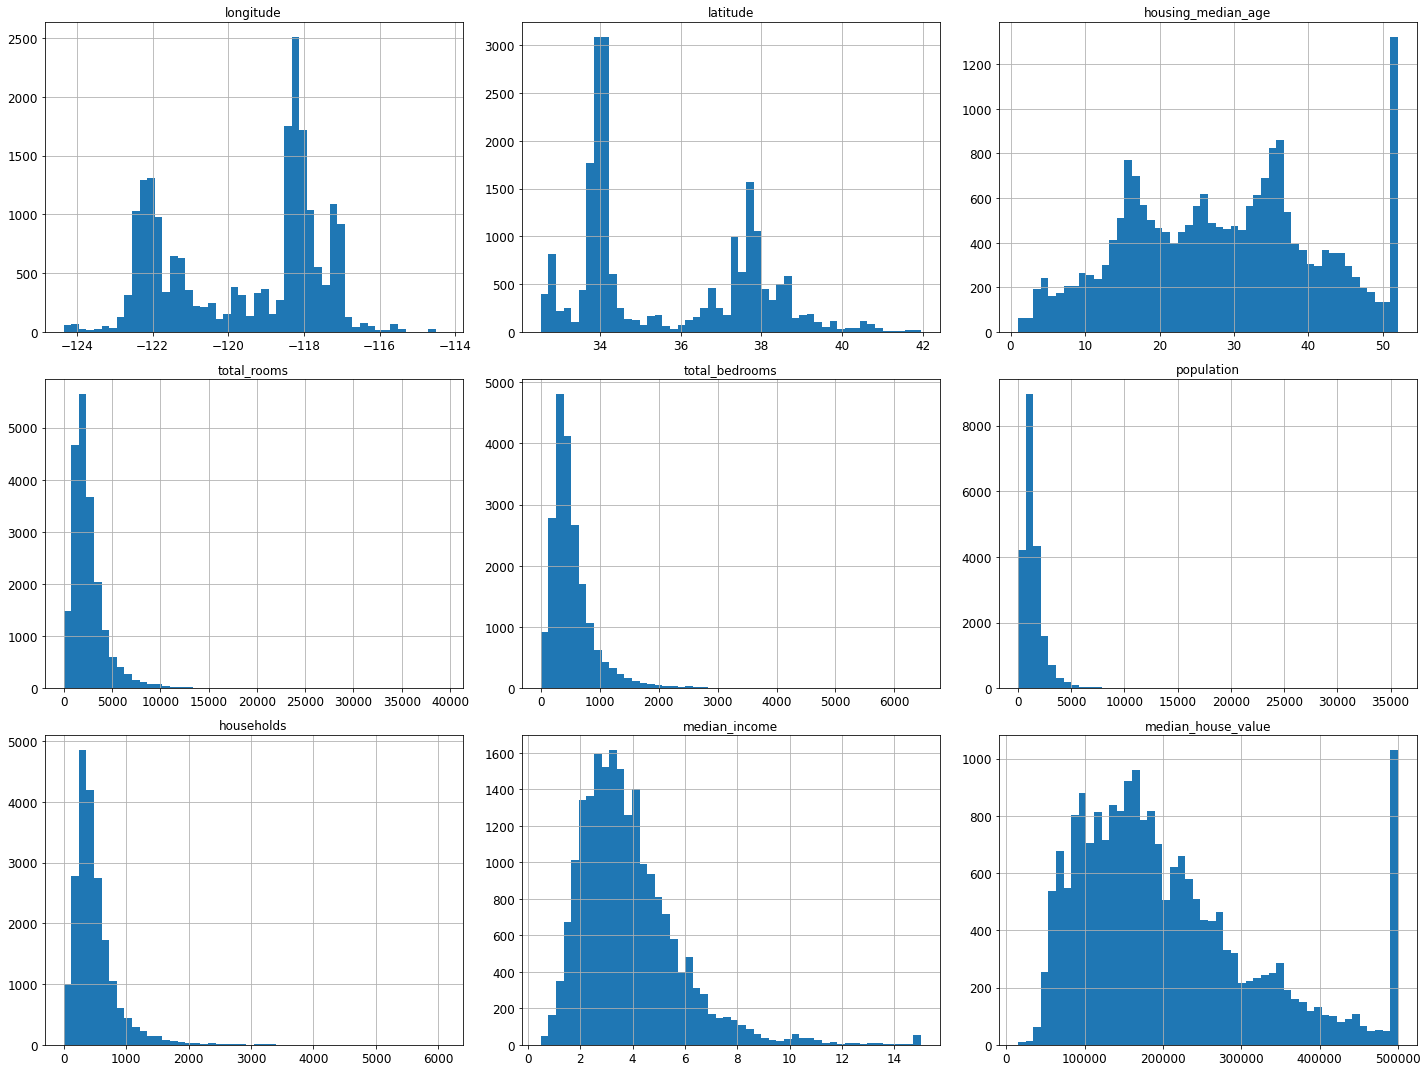

In [5]:
%matplotlib inline
sid181061.hist(bins=50,figsize=(20,15))  #히스토그램으로 numeric feature 살펴보기. (범위에 대한 샘플 수 표현)
save_fig("attribute_histogram_plots")
plt.show()

## feature간 scale이 다르다. long tail feature도 존재한다. => 정규화 등 분포 조정이 필요하다

In [6]:
np.random.seed(42) #랜덤시드 고정
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(sid181061, test_size=0.2, random_state=42)

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = sid181061.loc[train_index]
    strat_test_set = sid181061.loc[test_index]

NameError: name 'housing' is not defined

## 상관관계 조사

In [8]:
corr_matrix = sid181061.corr()#피어슨 상관계수 (선형적인 관계만 파악)
corr_matrix["median_house_value"].sort_values(ascending=False) #label과의 상관계수 파악.
#median_income이 0.688로 압도적으로 강한 상관계수를 가짐

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

In [10]:
corr_matrix["total_bedrooms"].sort_values(ascending=False)
#침실의 개수와 세대 수, 총 방의 수, 인구 수가 상관계수가 높게나옴. 

total_bedrooms        1.000000
households            0.979728
total_rooms           0.930380
population            0.877747
longitude             0.069608
median_house_value    0.049686
median_income        -0.007723
latitude             -0.066983
housing_median_age   -0.320451
Name: total_bedrooms, dtype: float64

피어슨 상관계수로는 선형적인 관계만 파악할 수 있음
산점도로 파악하여 관계있는 특성 파악

그림 저장: scatter_matrix_plot


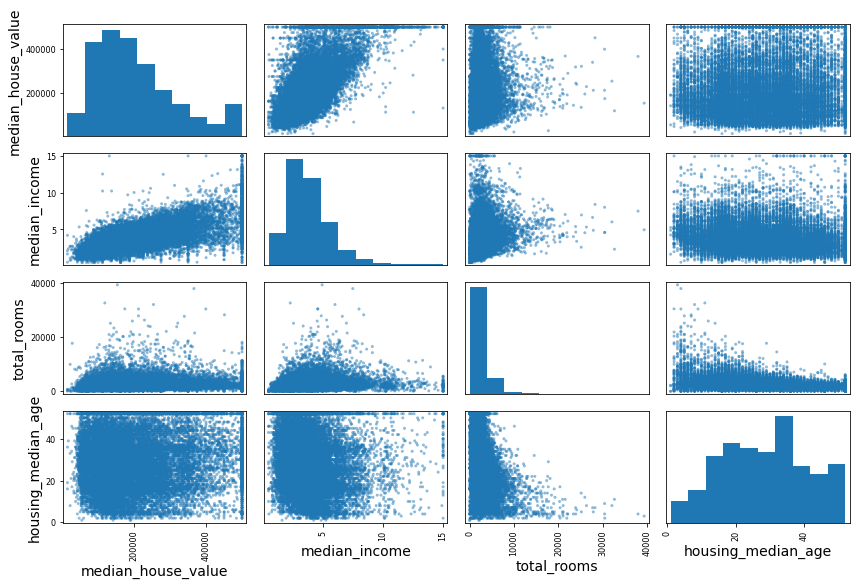

In [12]:
#scatter_matrix로 numeric feature간 산점도 파악
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]  
scatter_matrix(sid181061[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

## 새로운 feature 추가하기

In [14]:
sid181061["rooms_per_household"] = sid181061["total_rooms"]/sid181061["households"] # 가구수 대비 방의 갯수
sid181061["bedrooms_per_room"] = sid181061["total_bedrooms"]/sid181061["total_rooms"] # 전체방의 수 대비 침실수 
sid181061["population_per_household"]=sid181061["population"]/sid181061["households"] # 가구수 대비 인구수 

In [15]:
#새로운 특성으로 상관관계 분석. label은 주택 가격을 기준
#기존 feature인 total_rooms보다 새로운 feature인 rooms_per_household가 상관관계가 더 높음.
#기존 총 침실의 상관관계보다 전체 방 대비 침실의 상관관계가 더 높게나옴 => 침실/방 비율이 높을 수록 집값이 더 싸다
corr_matrix = sid181061.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

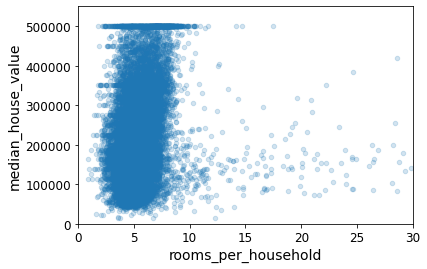

In [17]:
sid181061.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 30, 0, 550000])
plt.show()
#가구수 대비 방의 개수와 주택 가격 간의 산점도 확인. 가구 수가 1~10에 몰려있어 상관관계를 파악하기 어려움. 조정필요 

## 교차검증하기

#### 1.훈련데이터, 테스트데이터 분리

In [23]:
#중간 소득이 중간주택가격에 큰 영향을 미침. 이 빈도를 기준으로 훈련/테스트 셋 구성
sid181061["income_cat"] = pd.cut(sid181061["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(sid181061, sid181061["income_cat"]):
    strat_train_set =sid181061.loc[train_index]
    strat_test_set = sid181061.loc[test_index]

#### 2. 데이터 정제

In [54]:
sid181061 = strat_train_set.drop("median_house_value", axis=1) # 훈련 세트를 위해 레이블 삭제
sid181061_labels = strat_train_set["median_house_value"].copy()

## 스케일링하기

In [55]:
# 결측치가 있는 feature는 훈련데이터의 median값으로 채워넣음.
# SimpleImputer 사용 : median 으로 채우기
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
sid181061_num = sid181061.drop("ocean_proximity", axis=1) #numeric feature 에 대해서만 계산가능하므로 문자열 feature는 제외시킴
imputer.fit(sid181061_num)

SimpleImputer(strategy='median')

In [56]:
X = imputer.transform(sid181061_num)  # numpy array화
# 판다스 데이터프레임으로 변환
sid181061_tr = pd.DataFrame(X, columns=sid181061_num.columns,index=sid181061_num.index)

## 원핫인코딩 적용하기

In [57]:
sid181061_cat = sid181061[["ocean_proximity"]] #문자열 feature에 대한 처리

from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
sid181061_cat_1hot = cat_encoder.fit_transform(sid181061_cat)
print(sid181061_cat_1hot.toarray()) #원핫인코딩 결과 확인
print(cat_encoder.categories_)      #카테고리 리스트 확인

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]
[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


## 파이프라인 설계
 파이프라인 - 데이터 수집, 전처리, 모델 학습 배포 예측 등 머신러닝의 전체 과정을 순차적으로 처리하는 일련의 프로세스
  (입력 데이터가 들어왔을 때 이 데이터의 label을 예측하기까지 필요한 프로세스)

In [58]:
from sklearn.base import BaseEstimator, TransformerMixin
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [sid181061.columns.get_loc(c) for c in col_names]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin): # 속성 더해주는 클래스 (추가한 feature 적용)
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # 아무것도 하지 않습니다
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
sid181061_extra_attribs = attr_adder.transform(sid181061.to_numpy())

# 추가한 속성에 대하여 열 이름 복원.
sid181061_extra_attribs = pd.DataFrame(
   sid181061_extra_attribs,
    columns=list(sid181061.columns)+["rooms_per_household", "population_per_household"],
    index=sid181061.index)
sid181061_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household,income_cat,rooms_per_household,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN,4.625369,0.223852,2.094395,2,4.625369,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN,6.00885,0.159057,2.707965,5,6.00885,2.707965
14650,-117.2,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN,4.225108,0.241291,2.025974,2,4.225108,2.025974
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND,5.232295,0.200866,4.135977,2,5.232295,4.135977
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN,4.50581,0.231341,3.047847,3,4.50581,3.047847


In [59]:
# numeric feature 전처리 파이프라인

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

sid181061_num_tr = num_pipeline.fit_transform(sid181061_num)

In [60]:
#하나의 변환기로 각 열마다 다른 변환 적용

from sklearn.compose import ColumnTransformer

# 수치형 열이름 리스트
num_attribs = list(sid181061_num)

# 범주형 열이름 리스트
cat_attribs = ["ocean_proximity"]

# ColumnTransformer 객체 리스트
# 이름, 변환기, 변환기 적용될 열 이름(인덱스)
# num_pipeline은 위에서 정의

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

# num_pipeline은 밀집행렬, OneHotEncoder()은 희소행렬
# ColumnTransformer이 밀집도( 0이 아닌 원소의 비율)가 임계값보다 낮으면 희소행렬 반환
# 밀집도가 있어서 밀집행렬 반환


# 파이프라인을 housing 데이터에 적용
sid181061_prepared = full_pipeline.fit_transform(sid181061)

## 선형회귀, 결정트리, 랜덤포레스트 적용

In [61]:
# 선형회귀모델

from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(sid181061_prepared, sid181061_labels)

LinearRegression()

In [66]:
#데이터 몇개만 파이프라인에 적용하여 결과 확인 
some_data = sid181061.iloc[:5]
some_labels = sid181061_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("예측:", lin_reg.predict(some_data_prepared))
print("레이블:", list(some_labels))

#선형회귀 결과
from sklearn.metrics import mean_squared_error

sid181061_predictions = lin_reg.predict(sid181061_prepared)
lin_mse = mean_squared_error(sid181061_labels, sid181061_predictions)
lin_rmse = np.sqrt(lin_mse)
print("\n오차: ", lin_rmse) #오차가 너무 크다. 

예측: [200860.48973484 325527.93559759 201882.47991703  54956.04539331
 188116.26928254]
레이블: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]

오차:  67784.32202861732


In [68]:
# 결정트리

from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(sid181061_prepared, sid181061_labels)

sid181061_predictions = tree_reg.predict(sid181061_prepared)
tree_mse = mean_squared_error(sid181061_labels, sid181061_predictions)
tree_rmse = np.sqrt(tree_mse)
print("오차 : ",tree_rmse) #오차가 너무적다 => 과적합

오차 :  0.0


## 교차검증- 선형회귀, 결정트리, 랜덤포레스트

In [70]:
# 선형회귀 교차검증
lin_scores = cross_val_score(lin_reg, sid181061_prepared, sid181061_labels,scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

점수: [66140.5574445  66402.64250448 67308.08567538 73980.14151657
 67666.27878335 70758.72248018 63820.26082748 67347.49168296
 70423.45351656 67291.28882149]
평균: 68113.89232529681
표준 편차: 2722.3795780092782


In [69]:
# 결정트리 교차검증
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, sid181061_prepared,sid181061_labels,scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores) #socring을 효용함수로

def display_scores(scores):
    print("점수:", scores)
    print("평균:", scores.mean())
    print("표준 편차:", scores.std())

display_scores(tree_rmse_scores)

점수: [70910.85932789 66427.55261494 69799.21329454 70476.34411107
 69796.14615501 75581.78504247 69529.23606568 71121.13098257
 75965.26475135 71068.75381139]
평균: 71067.62861569086
표준 편차: 2680.746308632651


In [72]:
# 랜덤포레스트 : 특성을 무작위로 선택해서 다수의 결정트리 생성
# 예측을 평균, 앙상블 방법
# 100개의 트리 생성

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(sid181061_prepared, sid181061_labels)
forest_scores = cross_val_score(forest_reg, sid181061_prepared, sid181061_labels,scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

점수: [49524.58911362 47579.68850324 50057.04122655 52566.2892985
 49446.00816276 53321.80840442 48659.27563154 47532.71570713
 53417.86374944 50084.48965241]
평균: 50218.97694496087
표준 편차: 2076.265673020496


In [73]:
# 각 모델별 RMSE 출력

print("선형회귀:", lin_rmse_scores.mean())
print("결정트리:", tree_rmse_scores.mean())
print("랜덤포레스트:", forest_rmse_scores.mean())

선형회귀: 68113.89232529681
결정트리: 71067.62861569086
랜덤포레스트: 50218.97694496087


## 그리드 서치, 랜덤서치 적용

In [75]:
#그리드 탐색

from sklearn.model_selection import GridSearchCV

param_grid = [
    # 12(=3×4)개의 하이퍼파라미터 조합을 시도합니다.
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # bootstrap은 False로 하고 6(=2×3)개의 조합을 시도합니다.
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

# n_estimators : 결정트리 갯수
# max_features : feature 수

#  {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]} : 딕셔너리
# 3 일때 2,4,6,8 조합 실행

# 총 12+6 = 18번의 조합 탐색. 


# 랜덤포레스트로 그리드탐색

forest_reg = RandomForestRegressor(random_state=42)

# 다섯 개의 폴드로 훈련하면 총 (12+6)*5=90번의 훈련이 일어납니다.

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(sid181061_prepared, sid181061_labels)

print("최상의 파라미터 조합 : ",grid_search.best_params_)
print("최적의 추정기 : ",grid_search.best_estimator_)

최상의 파라미터 조합 :  {'max_features': 8, 'n_estimators': 30}
최적의 추정기 :  RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)


In [76]:
pd.DataFrame(grid_search.cv_results_) #데이터프레임으로 테이블뷰로 보기

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.046678,0.001718,0.002194,0.000400,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-4.176060e+09,-4.518963e+09,...,-4.322786e+09,1.411940e+08,18,-1.179823e+09,-1.154649e+09,-1.131922e+09,-1.187185e+09,-1.166445e+09,-1.164004e+09,1.954643e+07
1,0.157367,0.003299,0.007774,0.000397,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.093727e+09,-3.353044e+09,...,-3.262658e+09,1.401633e+08,11,-6.064716e+08,-5.985098e+08,-5.870169e+08,-6.299507e+08,-6.084402e+08,-6.060779e+08,1.411554e+07
2,0.460560,0.005249,0.020739,0.001166,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.771970e+09,-3.086563e+09,...,-2.967819e+09,1.464172e+08,7,-4.587687e+08,-4.480749e+08,-4.500988e+08,-4.672223e+08,-4.523894e+08,-4.553108e+08,6.955561e+06
3,0.076004,0.001718,0.002593,0.000489,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.627351e+09,-4.014368e+09,...,-3.822090e+09,2.026389e+08,16,-1.020063e+09,-1.039914e+09,-1.020809e+09,-1.059898e+09,-1.035346e+09,-1.035206e+09,1.461817e+07
4,0.244938,0.003754,0.007185,0.000391,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.834303e+09,-3.107612e+09,...,-2.987877e+09,1.412795e+08,8,-5.482497e+08,-5.518190e+08,-5.357821e+08,-5.648401e+08,-5.491348e+08,-5.499651e+08,9.268153e+06
5,0.729840,0.006669,0.019947,0.000632,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.593219e+09,-2.868377e+09,...,-2.765131e+09,1.626228e+08,3,-4.240145e+08,-4.184795e+08,-4.198612e+08,-4.310460e+08,-4.234936e+08,-4.233789e+08,4.372200e+06
6,0.102735,0.002532,0.002587,0.000484,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.733304e+09,-3.808093e+09,...,-3.734904e+09,1.422771e+08,13,-1.003142e+09,-9.729003e+08,-9.322720e+08,-1.026534e+09,-1.012629e+09,-9.894954e+08,3.359511e+07
7,0.341088,0.007847,0.007188,0.000409,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.812799e+09,-2.941667e+09,...,-2.898949e+09,1.288020e+08,5,-5.323886e+08,-5.375717e+08,-5.155862e+08,-5.787468e+08,-5.392404e+08,-5.407067e+08,2.078105e+07
8,1.012090,0.013606,0.020349,0.000491,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.625330e+09,-2.756942e+09,...,-2.726865e+09,1.307185e+08,2,-4.123451e+08,-4.071486e+08,-4.040150e+08,-4.354302e+08,-4.167371e+08,-4.151352e+08,1.104247e+07
9,0.131642,0.001779,0.002188,0.000402,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.572239e+09,-3.833130e+09,...,-3.737048e+09,1.397716e+08,14,-9.773909e+08,-1.035081e+09,-9.451906e+08,-1.000654e+09,-9.970017e+08,-9.910637e+08,2.951632e+07


In [78]:
# 랜덤 탐색 
# 탐색공간이 큰 경우, 설정값이 연속형일 경우
# 범위내 정수값을 균등분포로 추출(randint) 

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'n_estimators': randint(low=1, high=200),'max_features': randint(low=1, high=8), }

# 탐색 반복수n_iter=10

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(sid181061_prepared, sid181061_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000017203AB69D0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001720510CA30>},
                   random_state=42, scoring='neg_mean_squared_error')

In [79]:
pd.DataFrame(rnd_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,7.129825,0.182952,0.117883,0.001922,7,180,"{'max_features': 7, 'n_estimators': 180}",-2.460271e+09,-2.666533e+09,-2.770352e+09,-2.380211e+09,-2.698159e+09,-2.595105e+09,1.488577e+08,1
1,0.433637,0.002118,0.010180,0.000396,5,15,"{'max_features': 5, 'n_estimators': 15}",-2.695685e+09,-2.968345e+09,-2.977694e+09,-2.605194e+09,-2.942136e+09,-2.837811e+09,1.560775e+08,9
2,1.419595,0.006171,0.047679,0.000402,3,72,"{'max_features': 3, 'n_estimators': 72}",-2.579788e+09,-2.860153e+09,-2.973405e+09,-2.587029e+09,-2.885269e+09,-2.777129e+09,1.625994e+08,7
3,0.609966,0.001860,0.014362,0.000488,5,21,"{'max_features': 5, 'n_estimators': 21}",-2.654247e+09,-2.878519e+09,-2.896425e+09,-2.572494e+09,-2.911651e+09,-2.782667e+09,1.410175e+08,8
4,4.667213,0.014035,0.079583,0.000411,7,122,"{'max_features': 7, 'n_estimators': 122}",-2.479102e+09,-2.684243e+09,-2.788082e+09,-2.389255e+09,-2.724005e+09,-2.612937e+09,1.523430e+08,2
5,1.476644,0.003972,0.049874,0.000011,3,75,"{'max_features': 3, 'n_estimators': 75}",-2.577489e+09,-2.858382e+09,-2.965900e+09,-2.577071e+09,-2.883598e+09,-2.772488e+09,1.633057e+08,6
6,1.732013,0.004175,0.057852,0.000011,3,88,"{'max_features': 3, 'n_estimators': 88}",-2.590014e+09,-2.846712e+09,-2.961197e+09,-2.565388e+09,-2.896338e+09,-2.771930e+09,1.628773e+08,5
7,2.898644,0.001612,0.065619,0.000396,5,100,"{'max_features': 5, 'n_estimators': 100}",-2.541856e+09,-2.724707e+09,-2.831357e+09,-2.435994e+09,-2.805858e+09,-2.667955e+09,1.540425e+08,3
8,2.949306,0.004197,0.098145,0.001014,3,150,"{'max_features': 3, 'n_estimators': 150}",-2.568373e+09,-2.815703e+09,-2.931695e+09,-2.541700e+09,-2.846526e+09,-2.740800e+09,1.565894e+08,4
9,0.058836,0.000892,0.001795,0.000399,5,2,"{'max_features': 5, 'n_estimators': 2}",-4.222551e+09,-4.436825e+09,-4.621868e+09,-4.228349e+09,-4.381952e+09,-4.378309e+09,1.479910e+08,10
